<a href="https://colab.research.google.com/github/Satwikram/AI-Tutoring/blob/main/CV/Sign%20Language%20Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Author: Satwik Ram K

### Connecting to Kaggle

In [1]:
from google.colab import files

files.upload()


! mkdir ~/.kaggle


! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download -d ahmedkhanak1995/sign-language-gesture-images-dataset

 99% 189M/191M [00:02<00:00, 105MB/s] 
100% 191M/191M [00:02<00:00, 89.5MB/s]


### Unzipping the dataset

In [ ]:
!unzip /content/sign-language-gesture-images-dataset.zip

### Setup

In [ ]:
!pip install livelossplot

### Importing Dependencies

In [1]:
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm
import random

from pathlib import Path

from livelossplot.tf_keras import PlotLossesCallback
from livelossplot import PlotLossesKeras

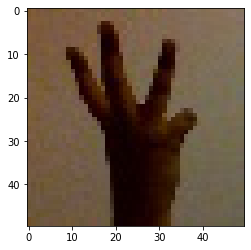

In [2]:
plt.imshow(plt.imread("/content/Gesture Image Data/6/1.jpg"))

### Load all the Images

In [3]:
uniq_labels = sorted(os.listdir('/content/Gesture Image Data'))

In [4]:
uniq_labels

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '_']

In [5]:
def load_dataset(directory):

  images = []
  labels = []

 
  for idx, label in tqdm(enumerate(uniq_labels)):
    for file in os.listdir(directory+label):
      filepath = directory+label+"/"+file
      img = cv2.resize(cv2.imread(filepath),(50,50))
      img = img /255
      
      images.append(img)
      labels.append(idx)

  images = np.asarray(images)
  labels = np.asarray(labels)
  return images, labels

### Loading Dataset

In [6]:
X, y = load_dataset('/content/Gesture Image Data/')

37it [00:23,  1.59it/s]


In [7]:

X.shape, y.shape

((55500, 50, 50, 3), (55500,))

In [8]:
y[1499]

0

### Converting to Categorical

In [9]:
y = tf.keras.utils.to_categorical(y, num_classes = len(uniq_labels))

In [10]:
y[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

### Splitting Data into train and test

In [11]:
len(X)*0.1

5550.0

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42, stratify=y)

In [14]:
uniq_labels[np.argmax(y_test[200])]

'Z'

### Checking

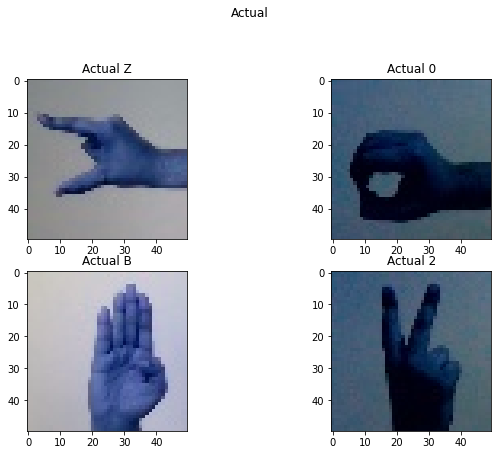

In [15]:
plt.figure(figsize = (10,10))
plt.subplot(3, 2, 1)
plt.imshow(X_test[200])
plt.title("Actual " + str(uniq_labels[np.argmax(y_test[200])]))

plt.subplot(3, 2, 2)
plt.imshow(X_test[2000])
plt.title("Actual "+ str(uniq_labels[np.argmax(y_test[2000])]))

plt.subplot(3, 2, 3)
plt.imshow(X_test[300])
plt.title("Actual "+ str(uniq_labels[np.argmax(y_test[300])]))

plt.subplot(3, 2, 4)
plt.imshow(X_test[350])
plt.title("Actual "+ str(uniq_labels[np.argmax(y_test[350])]))

plt.suptitle("Actual")
plt.show()

### Model Building

In [16]:
def build_model():

  model = tf.keras.models.Sequential([
                                      
          tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), strides = (1, 1), 
                                 activation = 'relu', input_shape = (50, 50, 3)),

          tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), strides = (1, 1), 
                                 activation = 'relu'),
                            
          tf.keras.layers.BatchNormalization(),
          
          tf.keras.layers.MaxPool2D(pool_size = (2, 2)),

          tf.keras.layers.GlobalAveragePooling2D(),

          tf.keras.layers.Dense(units = 256, activation = 'relu'),

          tf.keras.layers.BatchNormalization(),

          tf.keras.layers.Dense(units = 37, activation = 'softmax')

        ])

  model.summary()

  print("Model Successfully Created!")

  return model

In [17]:
model = build_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                        

### Compiling the model

In [18]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

### Loading Model

In [19]:
# loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Sign Language Prediction/model.h5')

### Creating Checkpoints and Callbacks

### Custom Callbacks

In [20]:
class ModelAnalysis(tf.keras.callbacks.Callback):

  def on_epoch_end(self, epoch, logs = None):

    plt.figure(figsize = (20,20))

    a = random.randint(0, 2775)
    plt.subplot(3, 2, 1)
    plt.imshow(X_test[a])
    plt.title("Actual class " + str(uniq_labels[np.argmax(y_test[a])]))

    plt.subplot(3, 2, 2)
    plt.imshow(X_test[a])
    test0 = np.expand_dims(X_test[a], axis = 0)
    plt.title("Predicted class " + str(uniq_labels[np.argmax(model.predict(test0))]))

    b = random.randint(0, 2775)

    plt.subplot(3, 2, 3)
    plt.imshow(X_test[b])
    plt.title("Actual class " + str(uniq_labels[np.argmax(y_test[b])]))

    plt.subplot(3, 2, 4)
    plt.imshow(X_test[b])
    test1 = np.expand_dims(X_test[b], axis = 0)
    plt.title("Predicted class " + str(uniq_labels[np.argmax(model.predict(test1))]))

    c = random.randint(0, 2775)

    plt.subplot(3, 2, 5)
    plt.imshow(X_test[c])
    plt.title("Actual class " + str(uniq_labels[np.argmax(y_test[c])]))

    plt.subplot(3, 2, 6)
    plt.imshow(X_test[c])
    test2 = np.expand_dims(X_test[c], axis = 0)
    plt.title("Predicted class " + str(uniq_labels[np.argmax(model.predict(test2))]))


    plt.suptitle("Model Analysis at Epoch")
    plt.show()


In [21]:
def callbacks() -> list:

    from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

    run_name = "run 1"
    save_path = Path("models")
    os.makedirs(save_path/"logs", exist_ok=True)
    
    checkpoint = ModelCheckpoint(save_path, monitor="val_loss", save_best_only=True, 
                                                    verbose=1)

    earlystopping = EarlyStopping(monitor="val_loss", verbose=1, restore_best_weights = True,
                                                    patience=5)

    logger = TensorBoard(save_path/"logs"/run_name, histogram_freq=2, write_graph=True, write_images=True)

    lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2, verbose=1,
                                         min_delta=0.0001, cooldown=0, min_lr=0)
    
    ob = ModelAnalysis()
    
    return [checkpoint, earlystopping, lr, logger, PlotLossesKeras(), ob]

### Training the Model

In [ ]:
history = model.fit(X_train, y_train, epochs = 5, batch_size = 64, verbose = 1,
                    validation_data = (X_test, y_test), shuffle = True,
                    callbacks = callbacks)

### Saving the History Variable

In [ ]:
import joblib

In [ ]:
joblib.dump(history.history, '/content/drive/MyDrive/Sign Language Prediction/history.pickle')